In [203]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.dataset import *
from torch.utils.data import DataLoader
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np
from tqdm.notebook import tqdm

In [204]:
def display_spectrogram(clear, sr=48000, x_axis='time', y_axis='linear'):
    amplitudeToDB = torchaudio.transforms.AmplitudeToDB()
    if len(clear.shape) == 4:
        clear = clear[0, 0, :, :]
    elif len(clear.shape) == 3:
        clear = clear[0, :, :]
    mag = amplitudeToDB(torch.abs(clear))
    librosa.display.specshow(mag.cpu().detach().numpy(),
        sr=sr,
        x_axis=x_axis,
        y_axis=y_axis
        )
    plt.colorbar(format="%+2.f")
    plt.show()


def display_phase(phase_spec, sr=48000, x_axis='time', y_axis='linear'):
    if len(phase_spec.shape) == 4:
        phase_spec = phase_spec[0, 0, :, :]
    elif len(phase_spec.shape) == 3:
        phase_spec = phase_spec[0, :, :]
    librosa.display.specshow(phase_spec.cpu().detach().numpy(),
        sr=sr,
        x_axis=x_axis,
        y_axis=y_axis
        )
    plt.colorbar(format="%+2.f")
    plt.show()

def spectogram_to_audio(mag, phase):
    H , W = mag.shape[-2], mag.shape[-1]

    mag = mag.cpu().detach().numpy()
    phase = phase.cpu().detach().numpy()
    mag = librosa.db_to_amplitude(mag)

    mag = torch.tensor(mag)
    phase = torch.tensor(phase)
    ctens = mag * np.exp(1j*phase)

    ctens = ctens.squeeze(0)
    assert ctens.shape == (1, H, W)
    wav = torch.istft(ctens, n_fft=1024, hop_length=512)
    wav = wav.reshape(1,-1)


    return wav


def wrap(x):
    """Wrap values to [-pi, pi)."""
    return ((x + torch.pi) % (2 * torch.pi)) - torch.pi

def compute_GD(psi):
    """Compute the group delay (GD) from the phase tensor."""
    psi_rolled = torch.roll(psi, shifts=-1, dims=0)  # Roll along the frequency axis
    gd = wrap(-psi_rolled + psi)
    return gd

def compute_IF(psi):
    """Compute the instantaneous frequency (IF) from the phase tensor."""
    psi_rolled = torch.roll(psi, shifts=-1, dims=1)  # Roll along the time axis
    ifr = wrap(psi_rolled - psi)
    return ifr

In [205]:
class SimpleCNNwithArctan(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(SimpleCNNwithArctan, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channel, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.out = nn.Conv2d(64, out_channels=out_channel, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.out(x)
        x = torch.atan2(x[:, 0], x[:, 1])
        return x

In [206]:
# dim testing
t = torch.randn(1, 1, 10, 10)

# model testing
model = SimpleCNNwithArctan(in_channel=1, out_channel=2)

# model output
output = model(t)

# output shape
print(output.shape)
print(torch.min(output))
print(torch.max(output))

torch.Size([1, 10, 10])
tensor(-3.1324, grad_fn=<MinBackward1>)
tensor(3.0230, grad_fn=<MaxBackward1>)


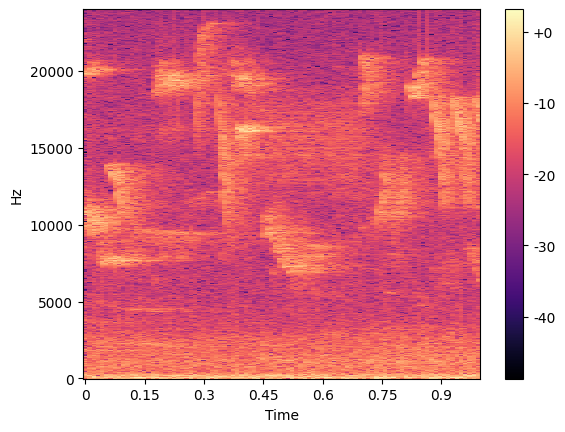

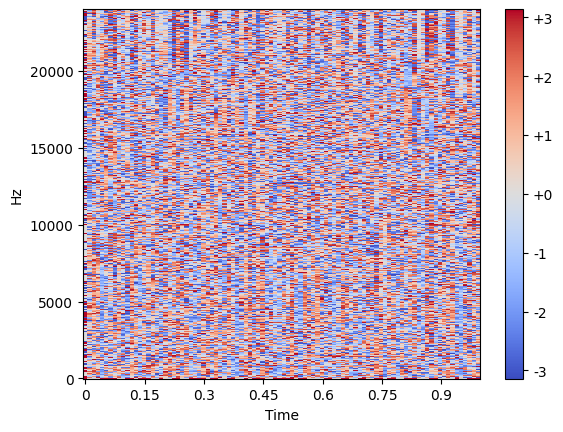

In [209]:
# Dataloading
from src.dataset import *

train_data = DataLoader(ds, batch_size=1, shuffle=True, num_workers=1)
batch = next(iter(train_data))
clear, noisy, mag, label = batch

display_spectrogram(torch.abs(clear))

display_phase(torch.angle(clear))



In [211]:
wav = torch.istft(clear[0,...], n_fft=1024, hop_length=512, win_length=1024)
Audio(wav, rate=16000)

In [212]:
# Training and testing the model
# Hyperparameters 

lr = 1e-4
epochs = 500
device = 'cpu'

model = SimpleCNNwithArctan(in_channel=1, out_channel=2)
model = model.to(device)
criterion = nn.L1Loss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training loop
model.train()

loop = tqdm(range(epochs))

for epoch in loop:
    loop.set_description(f'Epoch: {epoch+1}/{epochs}')
    clear, noisy, mag, label = batch
    clear = clear.to(device)
    noisy = noisy.to(device)
    mag = mag.to(device)

    phase = torch.angle(clear[0][0])



    # Forward pass
    pred = model(mag)

    # Loss function
    loss = criterion(pred.reshape(513,-1),phase.reshape(513,-1))

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    loop.set_postfix(loss=loss.item())









  0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([1, 513, 94])


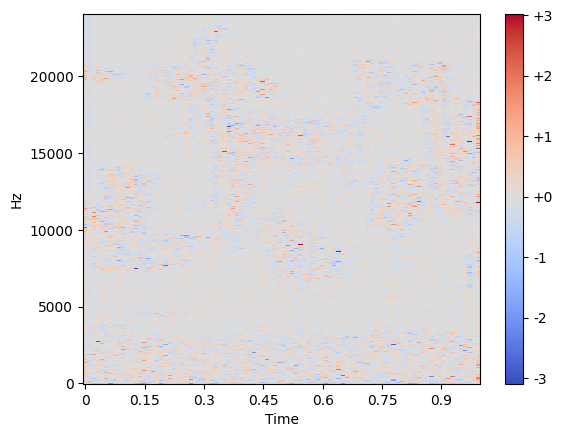

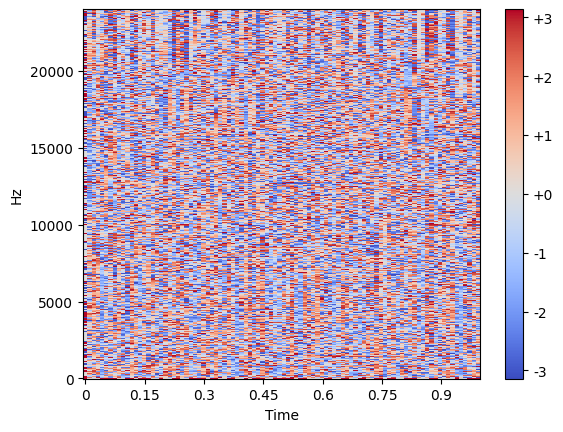

In [213]:
print(pred.shape)
display_phase(pred.unsqueeze(0))

phase = phase.reshape(1, 513, -1)
display_phase(phase.unsqueeze(0))

In [241]:
# Audio reconstruction Orginal
wav = torch.istft(noisy.squeeze(0), n_fft=1024, hop_length=512)
Audio(wav, rate=16000)

In [215]:
# Audio reconstruction Reconstructed
mag  = mag.reshape(1,1,513,-1)
phase = pred.reshape(1,1,513,-1)

wav = spectogram_to_audio(mag, phase)
Audio(wav, rate=16000)

In [216]:
# Experiment 2: With von Mises Loss

import torch
import torch.nn as nn
import torch.optim as optim

# 1. Define the neural network model G
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DNN, self).__init__()
        # Define the layers and activation functions
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size*2)
        self.fc3 = nn.Linear(hidden_size*2, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()  # You can use other activation functions as well
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)

        x = torch.atan2(torch.sin(x), torch.cos(x))
        
        return x




In [217]:
# dim testing
vm_model = DNN(128,512,128)
t = torch.randn(513,128)
dummy_phase = torch.atan2(3 * torch.randn(1, 1, 513,128), 7 * torch.randn(1, 1, 513,128))
# display_phase(dummy_phase)
out = vm_model(t).unsqueeze(0).unsqueeze(0)
# display_phase(out)

In [226]:
# # Set hyperparameters and initialize the model
model = DNN(94,512,94)
model.train()

mag_unbatched = mag[0,0,...].detach()
phase_unbatched = torch.angle(clear)
phase_unbatched = phase_unbatched[0,0,...]

org_GD = compute_GD(phase_unbatched)
org_IF = compute_IF(phase_unbatched)


assert org_GD.shape == org_IF.shape
assert org_GD.shape == (513,94)

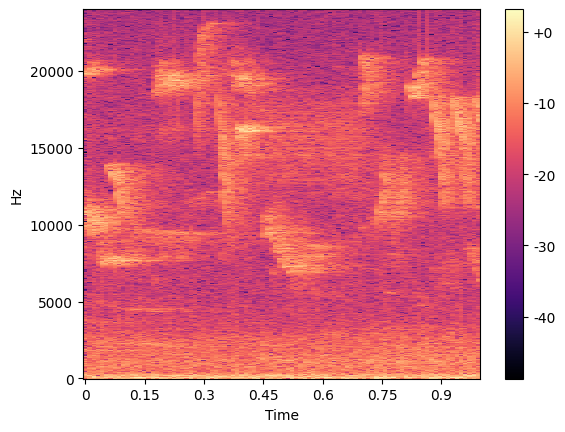

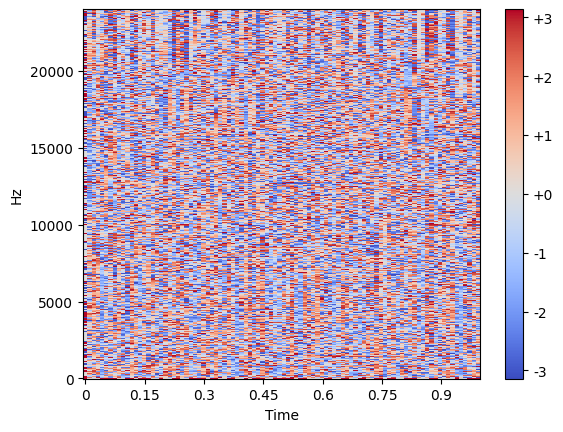

In [227]:
display_spectrogram(mag_unbatched)
display_phase(phase_unbatched)

  0%|          | 0/10000 [00:00<?, ?it/s]

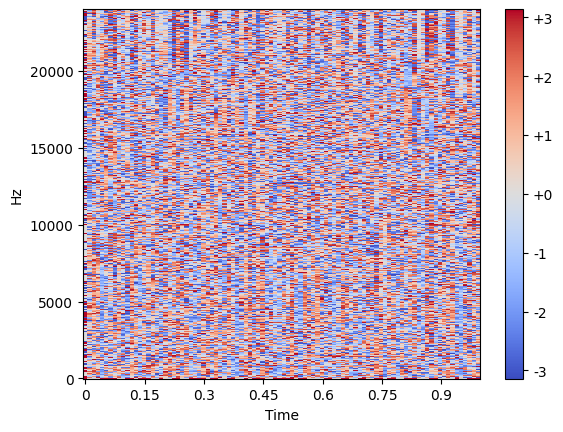

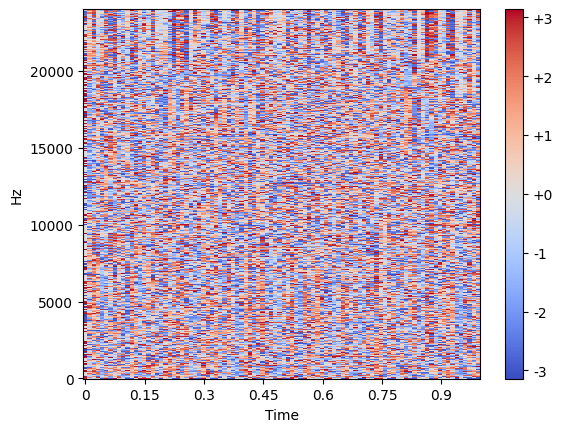

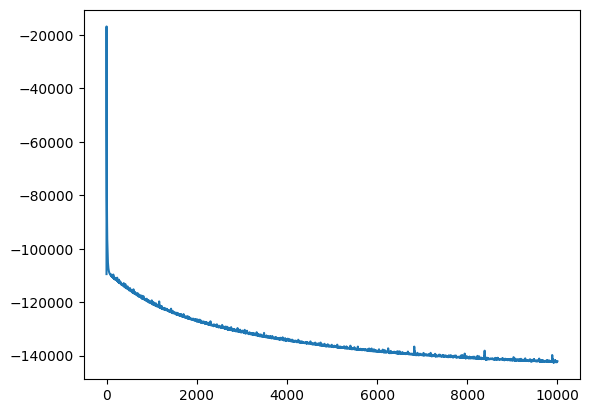

In [231]:
# 2. Define the loss function L_ph
def phase_loss(y, y_hat):
    return -torch.sum(torch.cos(y - y_hat)) 

def GD_loss(org_GD, recon_GD):
    return -torch.sum(torch.cos(org_GD - recon_GD)) 

def IF_loss( org_IF, recon_IF):
    return -torch.sum(torch.cos(org_IF - recon_IF))

def total_loss(y, y_hat, org_GD, recon_GD, org_IF, recon_IF):
    return phase_loss(y, y_hat,) + GD_loss(org_GD, recon_GD) + IF_loss(org_IF, recon_IF)


# 3. Train the model
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Example training loop (you will have to integrate your data loading mechanism here)
num_epochs = 10000


loop = tqdm(range(num_epochs))
losses = []
for epoch in loop:

    # Forward pass
    recon_phase = model(mag_unbatched)
    recon_GD = compute_GD(recon_phase)
    recon_IF = compute_IF(recon_phase)
    # loss = phase_loss(recon_phase, dummy_phase)

    loss = total_loss(recon_phase, phase_unbatched, org_GD, recon_GD, org_IF, recon_IF)

    losses.append(loss.item())
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loop.set_description('Epoch {}/{}'.format(epoch + 1, num_epochs))
    loop.set_postfix(loss=loss.item())




display_phase(phase_unbatched)
display_phase(recon_phase)

plt.plot([x for x in range(len(losses))], losses)

In [232]:
# Audio reconstruction Reconstructed
unbatched_mag  = mag_unbatched.reshape(1,1,513,-1)
phase = recon_phase.reshape(1,1,513,-1)

wav = spectogram_to_audio(mag, phase)
Audio(wav, rate=16000)

In [238]:
phase_unbatched

tensor([[ 3.1416e+00,  0.0000e+00,  0.0000e+00,  ...,  3.1416e+00,
          3.1416e+00,  3.1416e+00],
        [ 3.1416e+00,  2.1359e+00, -5.5734e-01,  ..., -2.7275e+00,
         -2.1302e-01, -3.0638e+00],
        [ 3.1416e+00, -2.8425e+00,  2.4154e+00,  ..., -3.0800e+00,
         -2.9961e+00,  2.4521e+00],
        ...,
        [ 3.1416e+00, -2.9011e+00,  2.8936e+00,  ...,  2.8435e+00,
          9.9105e-01, -1.4288e+00],
        [ 1.3290e-06, -1.7976e+00,  2.6775e+00,  ..., -3.1353e+00,
         -1.6005e-01,  3.1402e+00],
        [ 3.1416e+00,  3.1416e+00,  3.1416e+00,  ...,  3.1416e+00,
          0.0000e+00,  0.0000e+00]])

In [239]:
recon_phase

tensor([[ 2.9443, -0.3787, -0.2066,  ..., -3.0848, -3.0651, -3.0334],
        [ 3.0025,  1.8938, -0.5339,  ..., -2.6539, -0.2407, -3.0019],
        [ 3.0826, -2.9170,  2.4125,  ..., -2.9145, -2.9860,  2.5012],
        ...,
        [-1.7914,  0.3096,  2.9819,  ...,  2.4570, -0.0069, -2.5246],
        [-0.9267,  1.9615,  2.4044,  ...,  2.8731, -0.4839,  2.7974],
        [ 2.8122,  1.5855,  2.6693,  ...,  3.0826,  0.1403,  0.1873]],
       grad_fn=<Atan2Backward0>)